In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import os
import sys
from pathlib import Path

project_root = Path.cwd().parent
src_dir = project_root / "src"
sys.path.insert(0, str(src_dir))

from ts_prophet import ProphetModel
from ts_arima import ARIMAModel
from ts_day_of_year_statistic_model import DayOfYearStatisticModel

Importing plotly failed. Interactive plots will not work.


Dataframe to predict

In [3]:
all_flights = pd.read_csv(r'all_flights_daily.csv')
all_flights['DepTimeDateTime'] = pd.to_datetime(all_flights['DepTimeDateTime'])

In [4]:
all_flights = all_flights.sort_values(by='DepTimeDateTime').reset_index(drop=True)
all_flights = all_flights.drop_duplicates(subset=['DepTimeDateTime'])
all_flights = all_flights.dropna(subset=['DepTimeDateTime', 'FlightCount'])

<Axes: title={'center': 'Flight Count Over Time'}, xlabel='DepTimeDateTime'>

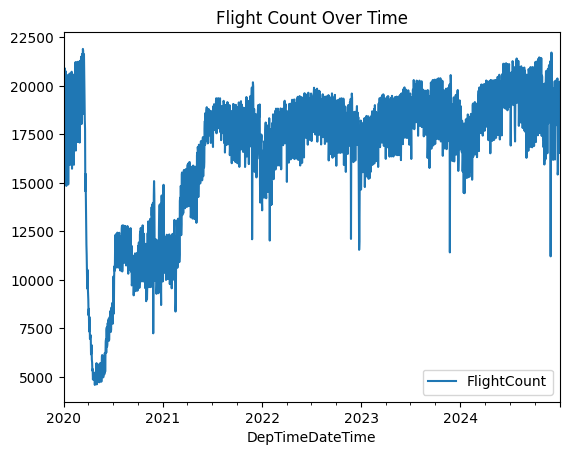

In [5]:
all_flights.plot(x='DepTimeDateTime', y='FlightCount', kind='line', title='Flight Count Over Time')

In [6]:
tscv = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=50)  # 30% of a year

First Prophet

In [7]:
model = ProphetModel()
model.train(all_flights['DepTimeDateTime'], all_flights['FlightCount']) 

11:45:22 - cmdstanpy - INFO - Chain [1] start processing
11:45:22 - cmdstanpy - INFO - Chain [1] done processing


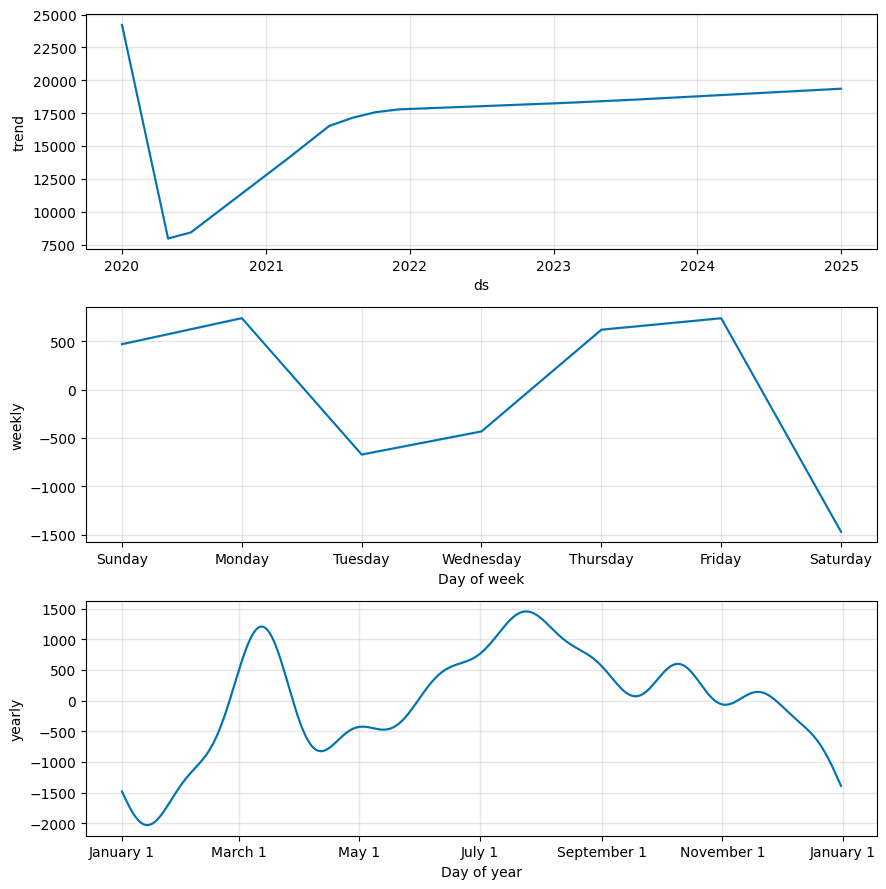

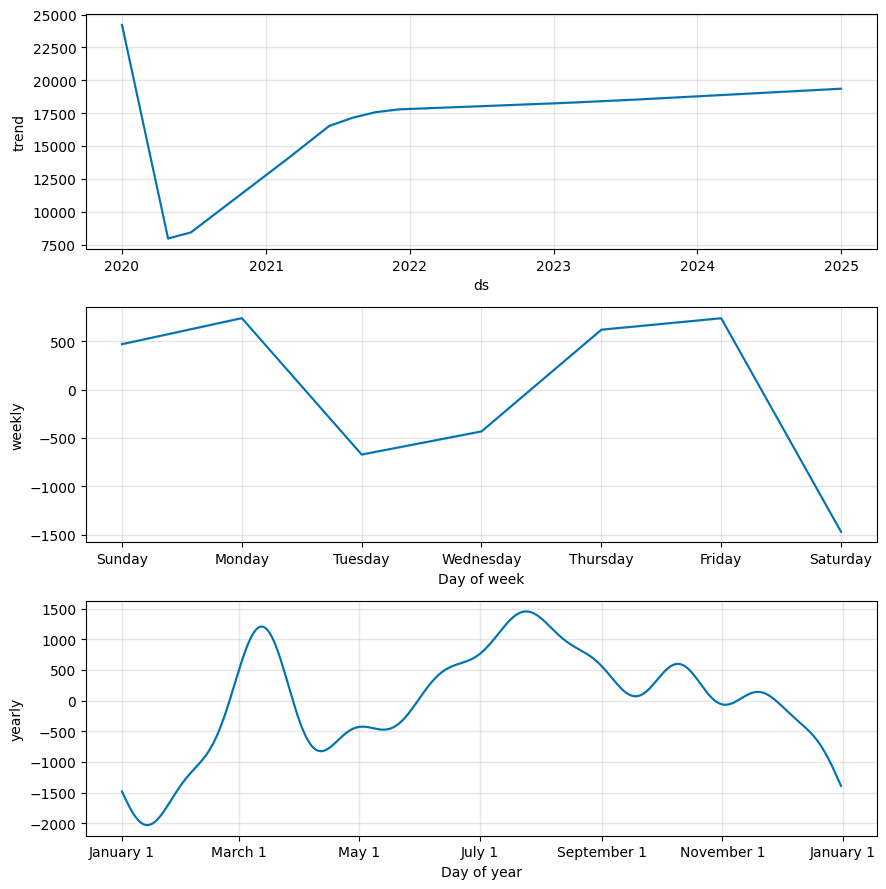

In [8]:
model.m.plot_components(model.predict(all_flights['DepTimeDateTime']))

In [9]:
# TS split evaluation
for train_index, test_index in tscv.split(all_flights):
    train, test = all_flights.iloc[train_index], all_flights.iloc[test_index]
    
    model = ProphetModel()
    model.m.add_country_holidays(country_name='US')
    model.train(train['DepTimeDateTime'], train['FlightCount'])
    predictions = model.predict(test['DepTimeDateTime'])
    
    mae = mean_absolute_error(test['FlightCount'], predictions['yhat'])
    mse = mean_squared_error(test['FlightCount'], predictions['yhat'])
    
    print(f'MAE: {mae}, MSE: {mse}')

11:45:25 - cmdstanpy - INFO - Chain [1] start processing
11:45:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1079.1031838668955, MSE: 1385811.3751627868


11:45:25 - cmdstanpy - INFO - Chain [1] start processing
11:45:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 884.5225195988913, MSE: 1598982.351125919


11:45:26 - cmdstanpy - INFO - Chain [1] start processing
11:45:26 - cmdstanpy - INFO - Chain [1] done processing


MAE: 963.9760618449162, MSE: 1380506.9877373846


11:45:26 - cmdstanpy - INFO - Chain [1] start processing
11:45:27 - cmdstanpy - INFO - Chain [1] done processing


MAE: 893.2118165809994, MSE: 1122131.5923080586


11:45:27 - cmdstanpy - INFO - Chain [1] start processing
11:45:27 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1024.4844974951789, MSE: 1490984.142692885


Dumbest Imaginable Model

Average of that day in each year

In [10]:
for train_index, test_index in tscv.split(all_flights):
    train, test = all_flights.iloc[train_index], all_flights.iloc[test_index]
    
    model = DayOfYearStatisticModel()
    model.train(train['DepTimeDateTime'], train['FlightCount'])
    predictions = model.predict(test['DepTimeDateTime'])
    
    mae = mean_absolute_error(test['FlightCount'], predictions['yhat'])
    mse = mean_squared_error(test['FlightCount'], predictions['yhat'])
    
    print(f'MAE: {mae}, MSE: {mse}')

MAE: 4770.965, MSE: 23790773.58875
MAE: 3416.04, MSE: 13218842.01
MAE: 2744.345, MSE: 9531027.51875
MAE: 2862.445, MSE: 10732750.53125
MAE: 2946.09, MSE: 11099368.0625


Testing Median as Well

In [11]:
for train_index, test_index in tscv.split(all_flights):
    train, test = all_flights.iloc[train_index], all_flights.iloc[test_index]
    
    model = DayOfYearStatisticModel(how='median')
    model.train(train['DepTimeDateTime'], train['FlightCount'])
    predictions = model.predict(test['DepTimeDateTime'])
    
    mae = mean_absolute_error(test['FlightCount'], predictions['yhat'])
    mse = mean_squared_error(test['FlightCount'], predictions['yhat'])
    
    print(f'MAE: {mae}, MSE: {mse}')

MAE: 2449.39, MSE: 6794177.045
MAE: 1787.82, MSE: 3904801.52
MAE: 1604.29, MSE: 3536079.045
MAE: 1730.01, MSE: 4215492.725
MAE: 2205.99, MSE: 7266343.935


Now for something that didn't quite work out: ARIMA. It's ultimately too finicky, and takes a lot more resources to run, so for now I'm thinking of running Prophet as our main forecasting tool.  

ARIMA

In [ ]:
all_flights = all_flights.iloc[500:500+100, :]

Determining optimal components of model

In [77]:
adf_test = adfuller(all_flights["FlightCount"])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.149236
p-value: 0.225183


In [78]:
# Difference once and check for stationarity
all_flights['FlightCount_diff'] = all_flights['FlightCount'].diff().dropna()
adf_test_diff = adfuller(all_flights['FlightCount_diff'].dropna())
print('ADF Statistic (Differenced): %f' % adf_test_diff[0])
print('p-value (Differenced): %f' % adf_test_diff[1])

ADF Statistic (Differenced): -3.756123
p-value (Differenced): 0.003390


Boxcox to control for heteroskedasticity

In [79]:
all_flights['FlightCount_boxcox'], lam = boxcox(all_flights['FlightCount'].dropna() + 1)  # Adding 1 to avoid log(0)
all_flights['FlightCount_boxcox_diff'] = all_flights['FlightCount_boxcox'].diff().dropna()

In [80]:
all_flights = all_flights.dropna(subset=['FlightCount_diff'])

Finding the autocorrelation and moving average orders

<Axes: title={'center': 'Differenced Flight Count Over Time'}>

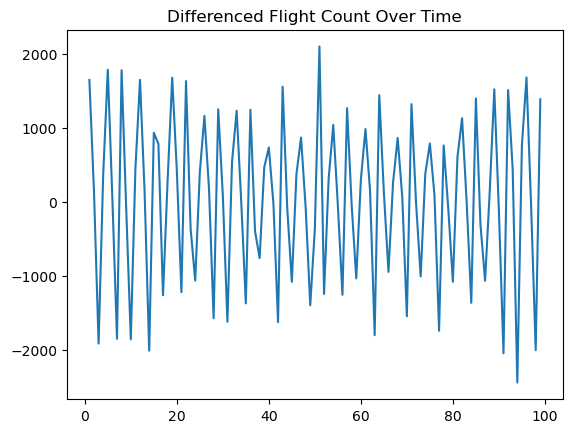

In [81]:
all_flights['FlightCount_diff'].plot(x='DepTimeDateTime', kind='line', title='Differenced Flight Count Over Time')

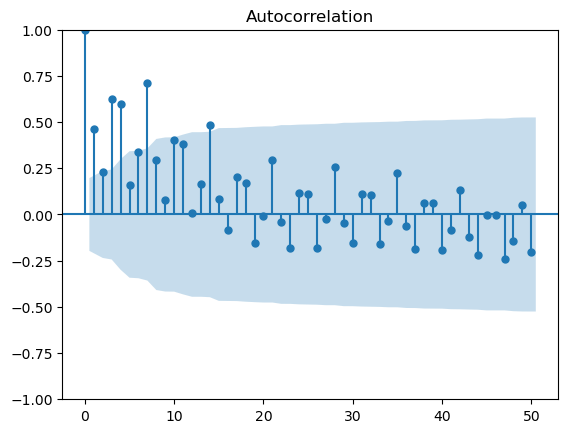

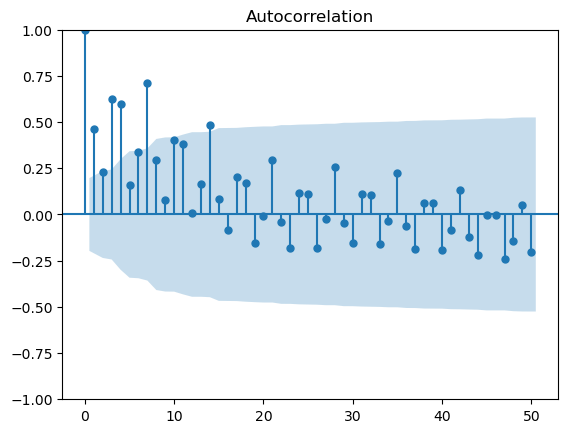

In [82]:
plot_acf(all_flights['FlightCount'], lags=50)

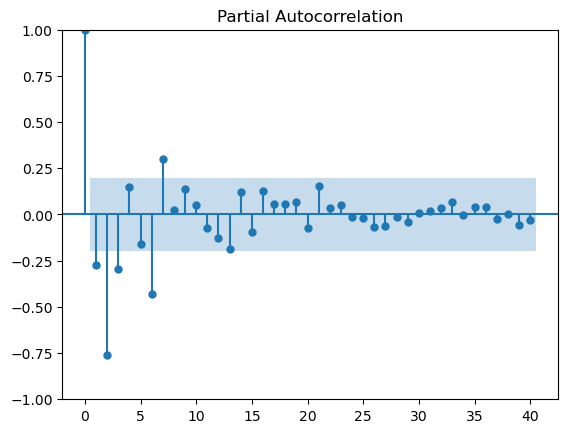

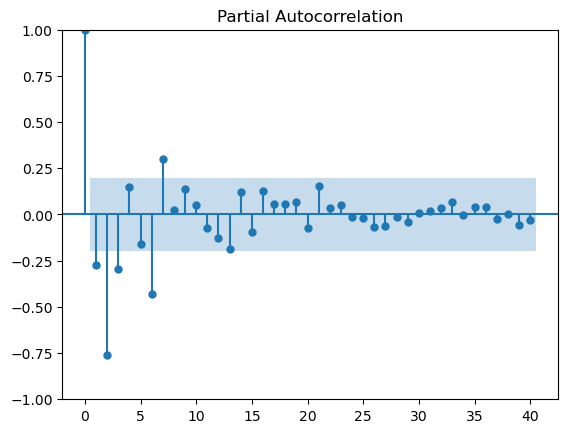

In [83]:
plot_pacf(all_flights['FlightCount_diff'], lags=40)

p order should be 31 and q order should be 365

Differencing once is sufficient

In [111]:
n = len(all_flights['FlightCount_diff'])
t = np.arange(1, n+1)          # 1,2,...,n
t2 = t**2                      # quadratic term
exog = pd.DataFrame({'c': 1, 't2': t2}, index=all_flights['DepTimeDateTime'])

In [112]:
model = ARIMAModel(order=(30, 1, 30), model_kwargs=dict(trend='n', seasonal_order=(1, 1, 1, 31), exog=exog))
model.train(all_flights['DepTimeDateTime'], all_flights['FlightCount'])



c:\Users\kikomwen\.conda\envs\dexterraenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kikomwen\.conda\envs\dexterraenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kikomwen\.conda\envs\dexterraenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kikomwen\.conda\envs\dexterraenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\kikomwen\.con

In [118]:
boxcox_predictions = model.predict(all_flights['DepTimeDateTime'], predict_kwargs=dict(exog=exog, type='levels'))
# predictions = inv_boxcox(boxcox_predictions, lam)
predictions = boxcox_predictions.copy()

c:\Users\kikomwen\.conda\envs\dexterraenv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
model._fitted_model.predict(steps=10, exog=exog.iloc[-10:], type='levels').plot()

In [121]:
model._fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          FlightCount   No. Observations:                   99
Model:             ARIMA(30, 1, 30)x(1, 1, [1], 31)   Log Likelihood                -534.593
Date:                              Thu, 10 Jul 2025   AIC                           1199.186
Time:                                      18:05:38   BIC                           1342.491
Sample:                                  05-16-2021   HQIC                          1255.892
                                       - 08-22-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c          -7.305e-06   1.51e+04  -4.84e-10      1.000   -2.96e+04    2.96e+04
t2            -0.6480     94.798     -0.007      0.995    -186.448     185.152
ar.L1          0.3138    275.363      0.001      0.999    -539.389     540.016
ar.L2          0.5092     58.473      0.009      0.993    -114.096     115.114
ar.L3         -0.5014    121.019     -0.004      0.997    -237.695     236.692
ar.L4         -0.2767     84.926     -0.003      0.997    -166.728     166.175
ar.L5          0.7027    200.524      0.004      0.997    -392.316     393.722
ar.L6         -0.1447    107.720     -0.001      0.999    -211.272     210.983
ar.L7         -0.3803     39.042     -0.010      0.992     -76.902      76.141
ar.L8          0.2861     24.149      0.012      0.991     -47.046      47.618
ar.L9          0.1918     51.492      0.004      0.997    -100.730     101.114
ar.L10        -0.3132     80.805     -0.004      0.997    -158.689     158.062
ar.L11        -0.0407     63.846     -0.001      0.999    -125.178     125.096
ar.L12         0.1630     56.186      0.003      0.998    -109.960     110.286
ar.L13        -0.1040    127.058     -0.001      0.999    -249.133     248.925
ar.L14         0.1016     31.236      0.003      0.997     -61.120      61.323
ar.L15        -0.0219     32.696     -0.001      0.999     -64.104      64.060
ar.L16        -0.1151     28.283     -0.004      0.997     -55.549      55.319
ar.L17         0.2421     36.391      0.007      0.995     -71.083      71.567
ar.L18         0.0569     18.756      0.003      0.998     -36.705      36.819
ar.L19        -0.3523     17.522     -0.020      0.984     -34.695      33.991
ar.L20         0.1213    124.813      0.001      0.999    -244.507     244.750
ar.L21         0.3923     40.369      0.010      0.992     -78.730      79.514
ar.L22        -0.5530    173.132     -0.003      0.997    -339.885     338.778
ar.L23        -0.3995    127.730     -0.003      0.998    -250.746     249.947
ar.L24         0.8194    126.575      0.006      0.995    -247.262     248.901
ar.L25        -0.1192    233.112     -0.001      1.000    -457.010     456.772
ar.L26        -0.4792     55.418     -0.009      0.993    -109.097     108.138
ar.L27         0.3268    141.900      0.002      0.998    -277.791     278.445
ar.L28         0.4031     47.942      0.008      0.993     -93.561      94.367
ar.L29        -0.5009    130.173     -0.004      0.997    -255.635     254.633
ar.L30         0.0707     53.927      0.001      0.999    -105.625     105.766
ma.L1         -0.4524    289.967     -0.002      0.999    -568.777     567.872
ma.L2         -0.7578    111.381     -0.007      0.995    -219.061     217.545
ma.L3          0.7299    194.999      0.004      0.997    -381.462     382.921
ma.L4          0.5032    140.985      0.004      0.997    -275.822     276.828
ma.L5         -1.0449    268.001  

In [119]:
predictions

1     25080.317343
2     23907.259936
3     24658.439873
4     24993.520822
5     24805.117310
          ...     
95    26916.009148
96    24214.554581
97    26653.561000
98    28071.997138
99    24728.244276
Name: FlightCount, Length: 99, dtype: float64

Text(0.5, 1.0, 'Flight Count Prediction')

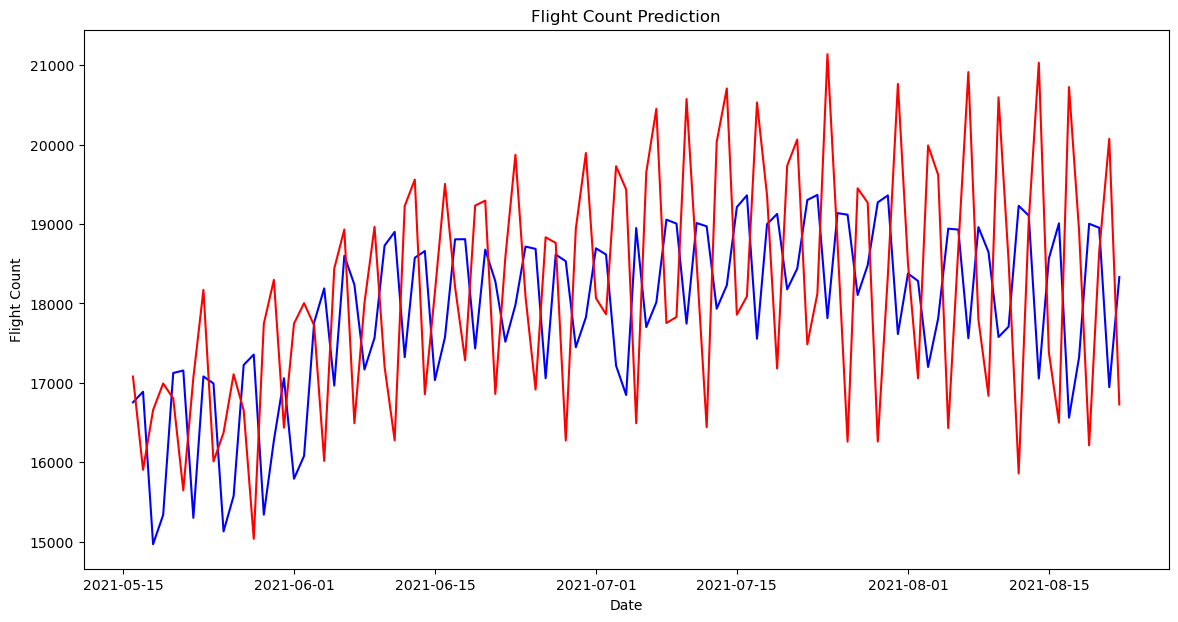

In [120]:
# Plot predictions and original data
plt.figure(figsize=(14, 7))
plt.plot(all_flights['DepTimeDateTime'], all_flights['FlightCount'], label='Actual', color='blue')
plt.plot(all_flights['DepTimeDateTime'], predictions-8000, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Flight Count')
plt.title('Flight Count Prediction')